In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


# Generate a count matrix of random noise

We want our factor model to tell us that this is just noise

In [2]:
N = 50000
D = 30
P = 3

# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': np.random.poisson(1.0, size=(N, D)),
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(10000)


Currently, the input data has to be in this format, as a tensorflow BatchDataset object with the given key/values.

# Set up the inference object

In [3]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    u_tau_scale=1.0/P/D/np.sqrt(N)*1e-3,
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 30 -> Latent dim 3


## Test out the prior distributions

In [4]:
## 
sample = factor.joint_prior.sample(10)
# Compute the joint log probability of the sample
probs = factor.joint_prior.log_prob(sample)
sample_surrogate = factor.surrogate_distribution.sample(77)
probs_parts = factor.unormalized_log_prob_parts(
    **sample_surrogate, data=next(iter(data)))
prob = factor.unormalized_log_prob(
    **sample_surrogate,  data=next(iter(data)))



# Inference

In [5]:
losses = factor.calibrate_advi(
    num_epochs=50, rel_tol=1e-4, learning_rate=.1)



W0521 16:00:11.959895 4713360832 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 52.059446546435964
Epoch 1: average-batch loss: 46.26315832717439 last batch loss: 41.28391611574196
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 40.59324960799382 last batch loss: 38.49120640117935
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 37.479789702868324 last batch loss: 36.92754404674349
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 36.215794069776805 last batch loss: 36.18518639300415
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 35.91048186902074 last batch loss: 35.907452562254754
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 35.90600237794964 last batch loss: 35.975842684580414
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 35.90492177061298 last batch loss: 35.93856186025684
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 35.91257433606606 last batch loss: 35.89764226639178
We are in a loss plateau le

# Compute the WAIC

In [6]:
waic = factor.waic()
print(waic)

{'waic': 1126905.2664148048, 'se': 1217.705241412601, 'lppd': -410789.27944339823, 'pwaic': 152663.3537640042}


# Plot the factor encoding matrix

In [7]:
surrogate_samples = factor.surrogate_distribution.sample(1000)
weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
intercept_data = az.convert_to_inference_data(
    {
        r"$w_d$": 
            (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor.norm_factor).numpy().T})

In [8]:
factor.intercept_matrix()

<tf.Tensor: shape=(1, 30), dtype=float64, numpy=
array([[0.95333764, 0.95737283, 0.95131589, 0.96035974, 0.95602418,
        0.96812555, 0.97316182, 0.95279597, 0.9689388 , 0.96148673,
        0.95861378, 0.96119517, 0.9509343 , 0.96427938, 0.9679082 ,
        0.96127117, 0.9503966 , 0.95700991, 0.94844204, 0.96085442,
        0.95545641, 0.95527032, 0.96052719, 0.96009854, 0.96707851,
        0.96199038, 0.96896671, 0.90900482, 0.95663315, 0.94637118]])>

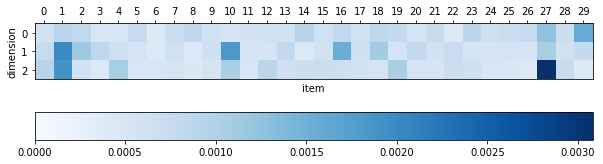

In [9]:
fig, ax = plt.subplots(figsize=(10,4))

plt.imshow(factor.encoding_matrix().numpy().T, vmin=0, cmap="Blues")
plt.xticks(np.arange(D))
ax.set_xlabel("item")
ax.set_ylabel("dimension")
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.yticks(np.arange(P))
plt.colorbar(orientation = "horizontal")
plt.show()


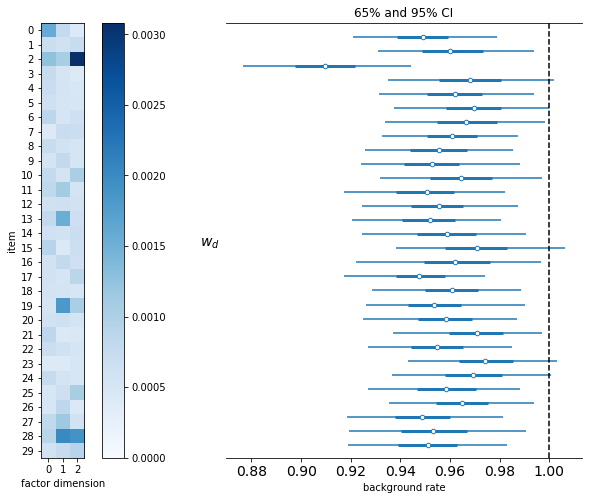

In [10]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.savefig('noise_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


The values in the factor encoding matrix as near zero. There is a gradient because the model induces a dimensional decay to remove symmetries - this encourages the leading dimensions to hold more of the signal.

In [11]:
factor.calibrated_expectations['s']/tf.reduce_sum(factor.calibrated_expectations['s'], axis=0, keepdims=True)

<tf.Tensor: shape=(2, 30), dtype=float64, numpy=
array([[0.2362347 , 0.24087933, 0.23854794, 0.23993028, 0.24416113,
        0.23976315, 0.23433853, 0.23636954, 0.23750465, 0.23249601,
        0.23662609, 0.23517676, 0.23372248, 0.23703863, 0.24187367,
        0.23677087, 0.24674438, 0.23104004, 0.2372224 , 0.23906781,
        0.2395541 , 0.23572896, 0.2374418 , 0.24101812, 0.23608085,
        0.23330573, 0.23741193, 0.2488472 , 0.23714061, 0.24324769],
       [0.7637653 , 0.75912067, 0.76145206, 0.76006972, 0.75583887,
        0.76023685, 0.76566147, 0.76363046, 0.76249535, 0.76750399,
        0.76337391, 0.76482324, 0.76627752, 0.76296137, 0.75812633,
        0.76322913, 0.75325562, 0.76895996, 0.7627776 , 0.76093219,
        0.7604459 , 0.76427104, 0.7625582 , 0.75898188, 0.76391915,
        0.76669427, 0.76258807, 0.7511528 , 0.76285939, 0.75675231]])>

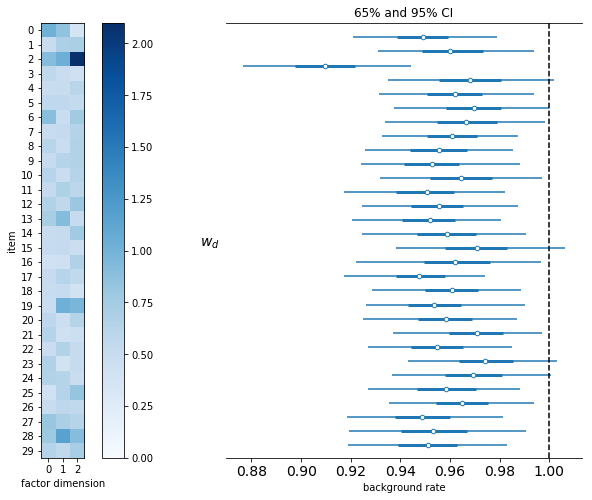

In [12]:
fig, ax = plt.subplots(1,2, figsize=(14,8))

pcm = ax[0].imshow(factor.decoding_matrix().numpy().T[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.show()
